In [16]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [2]:
df = pd.read_excel(str(Path(os.getcwd()).parent) + "/" + "sample_data/Mexico_Input_data.xlsx")

In [17]:
df = pd.read_csv(str(Path(os.getcwd()).parent) + "/" + "sample_data/Mexico_IHS_data.csv")

In [18]:
df.head()

,Geography,Concept,Unit,Frequency,Period,Value
0,Mexico,Index: Labor Productivity: GDP-to-Employed Lab...,Percent change year ago,Annual,1/1/2017,0.877104
1,Mexico,Index: Labor Productivity: GDP-to-Employed Lab...,Percent change year ago,Annual,1/1/2018,-0.439214
2,Mexico,Index: Labor Productivity: GDP-to-Employed Lab...,Percent change year ago,Annual,1/1/2019,-2.496296
3,Mexico,Index: Labor Productivity: GDP-to-Employed Lab...,Percent change year ago,Annual,1/1/2020,-1.326178
4,Mexico,Index: Labor Productivity: GDP-to-Employed Lab...,Percent change year ago,Annual,1/1/2021,-2.609037


In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# Example dataset
# Replace this with your actual dataset
data = (df['Volume']/100000).dropna().values

# Convert to pandas series
ts_data = pd.Series(data)

# Split data into train and test
train, test = ts_data[:-12], ts_data[-12:]

# Define models to test
models = {
    "ARIMA": ARIMA(train, order=(5,1,0)),
    "SimpleExpSmoothing": SimpleExpSmoothing(train),
    "HoltWinters": ExponentialSmoothing(train, seasonal='add', seasonal_periods=12)
}

# Add Prophet model
data_train = df[["Date", "Volume"]].dropna().reset_index().rename(columns={'Date': 'ds', "Volume": 'y'}).iloc[:-12,:]
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(data_train)
future = prophet_model.make_future_dataframe(periods=len(df[["Date", "Volume"]].dropna().reset_index().rename(columns={'Date': 'ds', "Volume": 'y'}).iloc[-12:,:]))
prophet_forecast = prophet_model.predict(future)

# Fit models and make predictions
predictions = {}
for name, model in models.items():
    model_fit = model.fit()
    predictions[name] = model_fit.forecast(len(test))
    
predictions['Prophet'] = prophet_forecast['yhat'][-len(test):]

# Calculate and print MSE for each model
for name, prediction in predictions.items():
    mse = mean_squared_error(test, prediction)
    print(f"{name} MSE: {mse}")


11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing


ARIMA MSE: 19.196905662795558
SimpleExpSmoothing MSE: 18.320942633856763
HoltWinters MSE: 5.582361096741235
Prophet MSE: 12624899624257.623


<Axes: >

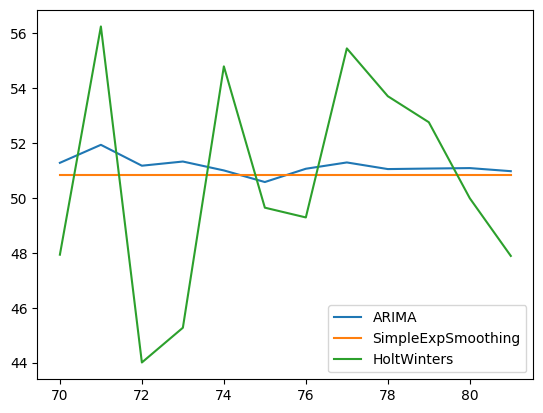

In [15]:
pd.DataFrame(predictions).drop('Prophet', axis = 1).plot()